Test Psycle Analytics<a id="top"></a>
===


**Questions**
- Quantification de la réussite ?
- Est-ce une analyse par client (par exemple, on analyse que pour le client numéro N) ou on analyse de manière globale (sur l'ensemble des clients) ?
- Je suppose qu'il y a des catégories de céréales, ne serait-ce pas intéressant de commencer l'analyse par là ? (certaines céréales se récoltent à différents moment de l'année)
- Est-il possible d'avoir des données sur 2 ou 3 années supplémentaires ? Les récoltes étant cycliques par année, pour réaliser ce type d'analyse, je pense qu'il est préférable d'avoir des données sur au moins 3 à 4 ans afin de faire ressortir ces cycles.


**Notes rapide**

Ce qui est faisable et intéressant :
- Faire une table qui analysera toutes les fluctuations journalières (j - j-1)
- Analyser ces fluctuations par jour sur l'ensemble des clients et des produits
- Analyser ces fluctuations par jour sur l'ensemble des clients par produits (attention à la quantité, prendre les plus représentés ? les plus fluctuants ?)
- Faire un modèle temporel (modèle ARIMA ?)
- Faire des recommendations
```python
df.loc[df['client_id'] == '0308b58b-3fb4-4364-852c-0b7a1b562f32'].groupby(['product_id']).sum()
```


**Sommaire**
- [1. Sujet](#TestPsycle_Subject)
- [2. Exploration des données](#TestPsycle_2)
    - [2.1. Analyse rapide d'un fichier](#TestPsycle_2-1)
    - [2.2. Analyse global du stock de produit](#TestPsycle_2-2)
    - [2.3. Analyse de quelques produits](#TestPsycle_2-3)
    - [2.4. Analyse des 20 produits les plus échangés](#TestPsycle_2-4)
- [3. Pre traitement des données](#TestPsycle_3)
- [4. Modelling](#TestPsycle_4)
- [5. Résumé, résultats & conclusion](#TestPsycle_5)
- [6. Question bonus](#TestPsycle_6)

In [1]:
# To open and manipulate CSV
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly

# For the machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve 

# To verify if a file exists
import os

import datetime as dt

# For some test with ARIMA model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# For a progress bar
from ipywidgets import IntProgress
from IPython.display import display

# For Plotly plotting in Jupyter
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# Set base path
PATH = "./test-analytics-data-engineer/data/"

[Back to top](#top)

---
## 1. Sujet<a id="TestPsycle_Subject"></a>

Une coopérative vend des céréales a des industriels du secteur agro-alimentaire. Ces industriels souhaitent optimiser au maximum leurs stocks. La coopérative souhaite donc fournir un logiciel permettant de d'optimiser les stocks qu'elle vend a ses clients industriels.

La coopérative fournit des fichiers de stocks au jour le jour de ses différents acheteurs. Chaque fichier csv présent répresente l'état des stocks à un jour J de l'ensemble des clients de la coopérative.

**Objectif** : déterminer par quel(s) moyen(s) la coopérative peut optimiser les stocks de ses clients.

> Pas de quantification d'objectif, juste des propositions d'optimisation ?

[Back to top](#top)

---
## 2. Exploration des données<a id="TestPsycle_2"></a>

Analyse de la forme: 
- Notre target est la *quantité* de produit
- La structure des données est un modèle en étoile
- Nous avons 3 colonnes :
    - client_id : qualitative
    - product_id : qualitative
    - quantity : quantitative
- Il y a au total 26955284 lignes
    
Analyse de fond:
- Il y a 4 jours avec des valeurs surprenantes
- Il manque 10 jours 
- il y a 333 clients uniques
- il y a 7700 produits uniques


### 2.1. Analyse rapide d'un fichier<a id="TestPsycle_2-1"></a>

In [3]:
def open_one_day_csv(date):
    """
    open a csv and return it as a pandas.DataFrame
    
    args
        str : date for the concerning file
    return
        pandas.DataFrame
    """
    
    # Set columns names and precise the CSV separator
    return pd.read_csv(PATH + date + '.csv', names=['client_id', 'product_id', 'quantity'], sep=";")

In [4]:
# Open the file as a CSV
df = open_one_day_csv("20210219")

# Quick stats to analyse the file
print(f'* Stats about quantity :\n{df.quantity.describe()}\n')
print(f'* Total unique:\n\t- products : {len(df.product_id.unique())}\n\t- clients : {len(df.client_id.unique())}\n')

# Show 5 first lines
print('* The five first lines :\n')
df.head()

* Stats about quantity :
count    38674.000000
mean         7.387418
std         14.415633
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max        629.000000
Name: quantity, dtype: float64

* Total unique:
	- products : 4598
	- clients : 329

* The five first lines :



client_id                            product_id  \
0  258002ed-82ca-4a43-978d-0179aec8597f  2718f836-5215-457f-a981-dc7ea4de2c11   
1  258002ed-82ca-4a43-978d-0179aec8597f  d3dfa836-1387-4fed-84ce-2d81e3a20cca   
2  258002ed-82ca-4a43-978d-0179aec8597f  99e14809-3d7e-49dc-85ea-56789943ca25   
3  258002ed-82ca-4a43-978d-0179aec8597f  9bc63cf4-495c-4030-ab38-d87110bdbf96   
4  258002ed-82ca-4a43-978d-0179aec8597f  2101e70d-c337-4f2d-8eea-de5b66410d8e   

   quantity  
0        22  
1         4  
2        33  
3         4  
4         4

          quantity
count   329.000000
mean    868.392097
std    1082.889104
min       1.000000
25%     190.000000
50%     514.000000
75%    1052.000000
max    8228.000000


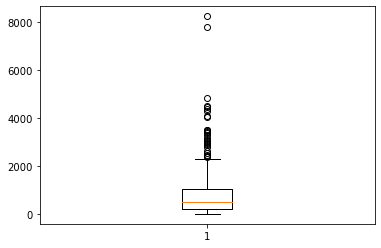

In [5]:
# Quick study of the client disparity
df_gb_client = df.groupby(['client_id']).sum()

# Show some stats
print(df_gb_client.describe())

# Plot stats
plt.boxplot(df_gb_client)
plt.show()

In [6]:
df_gb_client.sort_values('quantity')

quantity
client_id                                     
bf3ab949-4b0c-46a2-a4ed-130f8be5f454         1
f584420b-fd46-42bb-8783-4dc3d82675b0        12
47f3ccec-166c-4b0c-837d-b0f57d4563fc        12
2822ddee-a52f-4ec6-a742-dee296fd5546        15
8491515f-86a7-409e-920b-aa722a1bfe94        19
...                                        ...
f7b7645f-321d-4f91-a6b9-07fc456438b8      4471
05220653-551b-4853-8194-cecd77b74a93      4503
640bc630-8265-4ed9-bf5d-61e47f825177      4838
b1e199e0-15de-42b2-8762-930ee184e8ba      7762
ba5701a0-7085-415f-96f4-2d922e812b7b      8228

[329 rows x 1 columns]

Il est intéressant de constater que nous avons la majorité des clients qui on peut de produits en stock (moyenne à 868), mais il y a une forte disparité (écart type de 1082). On peut voir quelques groupe se former, l'un au niveau de 3000, un autre à 4000. Enfin, on a deux possibles outliers atteignant un stock de 8000.

          quantity
count  4598.000000
mean     62.135929
std     335.411265
min       1.000000
25%       2.000000
50%       6.000000
75%      23.000000
max    9844.000000


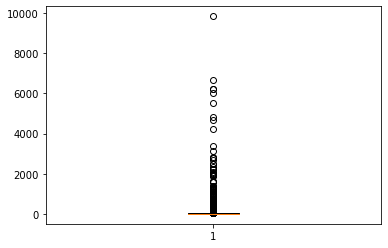

In [7]:
# Quick study of the product disparity
df_gb_product = df.groupby(['product_id']).sum()

# Show some stats
print(df_gb_product.describe())

# Plot stats
plt.boxplot(df_gb_product)
plt.show()

On voit très clairement une très forte disparité des données avec un écart type très élevé (335) comparé à la moyenne (62), elle-même bien supérieur au 3ème quartile (23).

[Back to top](#top)

---
### 2.2. Analyse globale du stock<a id="TestPsycle_2-2"></a>

In [8]:
# Initiate stock
stock = {
    'date': [],
    'quantity': []
}

# To know the total length and all unique values
total_length = 0
unique_products = []
unique_clients = []

error = []

for date in pd.date_range(start='2019-06-04', end='2021-03-10'):
    # Set the path (with leading zeros if needed)
    file = str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)
    
    # Verify if the file exists
    if not os.path.isfile(PATH + file + '.csv'):
        # Keep the problem
        error.append(PATH + file + '.csv')
        continue
        
    # Get the CSV
    df_temp = open_one_day_csv(file)
    
    # Update total length and unique product and clients
    total_length += len(df_temp)
    unique_products += list(set(df_temp.product_id.unique()) - set(unique_products))
    unique_clients += list(set(df_temp.client_id.unique()) - set(unique_clients))
    
    # Get the total product quantity per client and sum that
    quantity = df_temp.groupby(['client_id']).sum().sum()
    
    # Save the data
    stock.get('date').append(date)
    stock.get('quantity').append(quantity.values[0])
    
    # stock.update({date.date() : df_temp.loc[df_temp['client_id'] == '0308b58b-3fb4-4364-852c-0b7a1b562f32', ['quantity']].sum().values.tolist()})

# Transform as a DataFrame
stock = pd.DataFrame(stock.get('quantity'), index=stock.get('date'), columns=['quantity'])

# Quick analyse : stats
print(f'''
Total dataset length : {total_length}
Total unique product : {len(unique_products)}
Total unique client : {len(unique_clients)}
Total errors : {len(error)}

{stock.quantity.describe()}
''')

stock.head()


Total dataset length : 26955284
Total unique product : 7700
Total unique client : 333
Total errors : 10

count       636.000000
mean     303972.875786
std       36282.710594
min           0.000000
25%      283566.750000
50%      298889.500000
75%      323634.000000
max      375668.000000
Name: quantity, dtype: float64



quantity
2019-06-04  337663.0
2019-06-11  338487.0
2019-06-12  337226.0
2019-06-13  337257.0
2019-06-14  338083.0

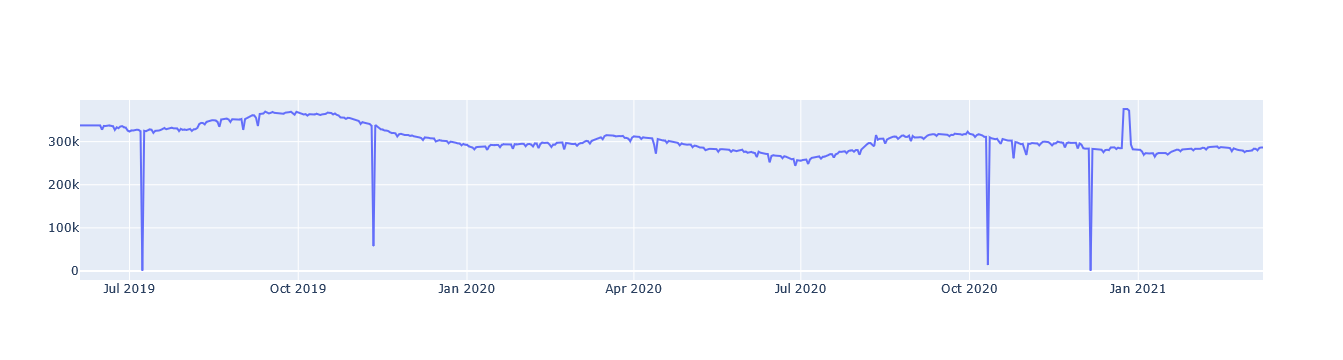

In [9]:
# To offer more interesting visualisations I have used Plotly (especially to allow is to zoom in)
trace0 = plotly.graph_objs.Scatter(x=stock.index.values, y=stock.quantity.values)
plotly.offline.iplot([trace0])

In [10]:
stock.loc[stock.quantity < 10e4]

quantity
2019-07-08       0.0
2019-11-11   56892.0
2020-10-11   13629.0
2020-12-06       0.0

In [11]:
stock.loc['2020'].loc[stock.loc['2020', 'quantity'] > 350000]

quantity
2020-12-24  375525.0
2020-12-25  375668.0
2020-12-26  375638.0
2020-12-27  371914.0

Il est très intéressant de voir ici quelques outlgroupbyrs :
* 4 pics vers le bas :
    - le 8 juillet 2019, le stock était vide (~~car c'était mon anniversaire ?~~ une erreur d'enregistrement ?)
    - le 11 novembre 2019, le stock était très bas (une erreur d'enregistrement pour certains clients ?)
    - le 11 octobre 2020, le stock était très bas (une erreur d'enregistrement pour certains clients ?)
    - le 6 décembre 2020, le stock était vide (une erreur d'enregistrement ?)
* 1 pic vers le haut du 24 au 27 décembre 2020 (prévision nouvel an ? commande spéciale ? erreur d'environ +90K sur le stock ?)

On peut remarquer qu'il y a une tendance à avoir un plus gros stock entre septembre et octobre (moment des récoltes (ex : vendanges) ?) et un stock plus léger en juillet et en janvier. **Il serait très intéressant de confirmer ces tendances avec des données sur un plus long terme (5 ans?)**.

Je vais rapidement voir si le pic au dans le stock est possiblement dû à une valeur aberrante:

In [12]:
print(f'''
Max of 20 december 2020 : {open_one_day_csv('20201220').groupby(['product_id']).sum().max()}
Max of 25 december 2020 : {open_one_day_csv('20201225').groupby(['product_id']).sum().max()}
''')


Max of 20 december 2020 : quantity    10953
dtype: int64
Max of 25 december 2020 : quantity    15449
dtype: int64



Il semblerait que non...

Maintenant, il serait intéressant d'étudier pour chaque produit l'évolution. En effet, il y a des céréales qui seront plus récoltées en été, d'autres à l'automne. afin de simplifier l'analyse, je vais essayer de trouver un seuil d'analyse pour ne filtrer et n'analyser que quelques produits. En effet, sachant qu'il y a quelques milliers de produits différents, tous les analyser en même temps serait compliqué.

[Back to top](#top)

---

### 2.3. Analyse de quelques produits<a id="TestPsycle_2-3"></a>

Je vais reprendre le code précédent et en faire une fonction "clean"df_temp.loc[df_temp.product_id == product_id]

In [13]:
# .loc[df_temp.product_id == '2718f836-5215-457f-a981-dc7ea4de2c11']
t = df_temp.groupby(['product_id']).sum()
t.at['00071e28-4e89-4771-bb28-9ee60df96e34', 'quantity']

183

In [14]:
def get_product_stock(product_id):
    # Initiate stock
    stock = {'date': [], 'quantity': [] }

    for date in pd.date_range(start='2019-06-04', end='2021-03-11'):
        # Set the path (with leading zeros if needed)
        file = str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

        # Verify if the file exists
        if not os.path.isfile(PATH + file + '.csv'):
            continue

        # Get the CSV
        df_temp = open_one_day_csv(file).groupby(['product_id']).sum()

        try:
            # Get the total product quantity per client and sum that
            quantity = df_temp.at[product_id, 'quantity']
        except:
            continue

        # Save the data
        stock.get('date').append(date)
        stock.get('quantity').append(quantity)
        
    # Transform as a DataFrame
    return pd.DataFrame(stock.get('quantity'), index=stock.get('date'), columns=['quantity_' + product_id])

df_product = get_product_stock('00071e28-4e89-4771-bb28-9ee60df96e34')
df_product.describe()

quantity_00071e28-4e89-4771-bb28-9ee60df96e34
count                                     634.000000
mean                                      146.356467
std                                        40.442017
min                                         4.000000
25%                                       113.000000
50%                                       162.000000
75%                                       182.000000
max                                       237.000000

<AxesSubplot:>

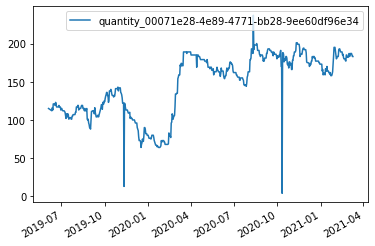

In [15]:
df_product.plot()

In [16]:
test = {'aaa':[], 'bbb':[], 'ccc':[]}
test['aaa'].append(5)
test

{'aaa': [5], 'bbb': [], 'ccc': []}

In [17]:
test = {}.fromkeys(['aaa', 'bbb', 'ccc'], [])
test['aaa'].append(5)
test

{'aaa': [5], 'bbb': [5], 'ccc': [5]}

In [18]:
test = {}.fromkeys(['aaa', 'bbb', 'ccc'], None)
for key in test.keys():
    test[key] = []
test['aaa'].append(5)
test

{'aaa': [5], 'bbb': [], 'ccc': []}

In [19]:
def get_products_fluxes(unique_selected_products, start='2019-06-04', end='2021-03-11'):
    # Init
    stock_products = {}.fromkeys(unique_selected_products, [])
    for key in stock_products.keys():
        stock_products[key] = []
    stock_products_date = []

    # Progress bar
    f = IntProgress(min=0, max=len(pd.date_range(start=start, end=end)))
    display(f) # display the bar

    for date in pd.date_range(start=start, end=end):
        f.value += 1 # signal to increment the progress bar
        # Set the path (with leading zeros if needed)
        file = str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

        # Verify if the file exists
        if not os.path.isfile(PATH + file + '.csv'):
            continue

        # Get the CSV
        df_temp = open_one_day_csv(file).groupby(['product_id']).sum()

        # Save the data
        # stock_products.get('date').append(date)
        stock_products_date.append(date)

        for product in unique_selected_products:
            if product in df_temp.index.values:
                stock_products.get(product).append(df_temp.at[product, 'quantity'])
            else:
                stock_products.get(product).append(np.nan)

        """for idx in set(unique_products) - set(df_temp.index.values):
            stock.get(idx).append(np.nan)"""
    return pd.DataFrame(stock_products, index=stock_products_date, columns=unique_selected_products)

stock_products = get_products_fluxes(unique_products[0:20])

stock_products.head()

IntProgress(value=0, max=647)

d65ca3f1-65bd-4cd8-b34b-3711a53724b3  \
2019-06-04                                 114.0   
2019-06-11                                 114.0   
2019-06-12                                 114.0   
2019-06-13                                 118.0   
2019-06-14                                 118.0   

            577108f6-40eb-4136-b523-2e70d4ff89e6  \
2019-06-04                                  14.0   
2019-06-11                                  18.0   
2019-06-12                                  18.0   
2019-06-13                                  18.0   
2019-06-14                                  18.0   

            47bae351-5638-435d-bbf5-bdf38cbd1963  \
2019-06-04                                   3.0   
2019-06-11                                   3.0   
2019-06-12                                   3.0   
2019-06-13                                   3.0   
2019-06-14                                   3.0   

            bda13da8-7715-41ab-9a59-441a7fe46564  \
2019-06-04                                  18.0   
2019-06-11                                  12.0   
2019-06-12                                  12.0   
2019-06-13                                  12.0   
2019-06-14                                  12.0   

            62af961f-0ba2-45d9-bf6c-ca83e3e94c20  \
2019-06-04                                   8.0   
2019-06-11                                   8.0   
2019-06-12                                   8.0   
2019-06-13                                   8.0   
2019-06-14                                   8.0   

            0871cfa6-fa60-490a-a77f-813f55d1f0a4  \
2019-06-04                                   4.0   
2019-06-11                                   4.0   
2019-06-12                                   4.0   
2019-06-13                                   4.0   
2019-06-14                                   4.0   

            084dae3e-7eb5-4c81-b0fa-88229a774a96  \
2019-06-04                                  11.0   
2019-06-11                                  11.0   
2019-06-12                                  11.0   
2019-06-13                                  11.0   
2019-06-14                                  11.0   

            4a6ae9ad-152b-424f-a560-0b28aa0dfee2  \
2019-06-04                                   4.0   
2019-06-11                                   4.0   
2019-06-12                                   4.0   
2019-06-13                                   4.0   
2019-06-14                                   4.0   

            8ac3f42b-d201-4ec7-9ad9-8f8e9e810c44  \
2019-06-04                                   2.0   
2019-06-11                                   2.0   
2019-06-12                                   2.0   
2019-06-13                                   2.0   
2019-06-14                                   2.0   

            64de0f3a-f5ba-407b-8ca7-5817b93c2f18  \
2019-06-04                                  76.0   
2019-06-11                                  74.0   
2019-06-12                                  74.0   
2019-06-13                                  74.0   
2019-06-14                                  74.0   

            f422da00-cbfb-4d5b-a263-4700b2e93cee  \
2019-06-04                                  77.0   
2019-06-11                                  63.0   
2019-06-12                                  59.0   
2019-06-13                                  58.0   
2019-06-14                                  58.0   

            0125583c-1434-4dbf-b52f-b1ac6d7c5232  \
2019-06-04                                   4.0   
2019-06-11                                   4.0   
2019-06-12                                   4.0   
2019-06-13                                   4.0   
2019-06-14                                   4.0   

            a074fac3-ad00-4cfc-98ad-73d07fa547f9  \
2019-06-04                                  79.0   
2019-06-11                                  75.0   
2019-06-12                                  75.0   
2019-06-13                                  75.0

In [20]:
missing = stock_products.isna().sum(axis=0)

pd.DataFrame({
    'sum_na': missing,
    'na_percent': missing/len(stock_products)
}, index=stock_products.columns).sort_values(by='sum_na')

sum_na  na_percent
084dae3e-7eb5-4c81-b0fa-88229a774a96       2    0.003145
d65ca3f1-65bd-4cd8-b34b-3711a53724b3       3    0.004717
68f4a4be-83be-466f-be7e-26f942026c9a       3    0.004717
a2b8ea0c-3a89-48e5-a3bc-c9f7f1a3971b       3    0.004717
b595323f-84f3-4b0c-b954-f62e913c4f1e       3    0.004717
3adbb568-284d-46ae-bd4a-c8ad502412eb       3    0.004717
64de0f3a-f5ba-407b-8ca7-5817b93c2f18       3    0.004717
62af961f-0ba2-45d9-bf6c-ca83e3e94c20       3    0.004717
bda13da8-7715-41ab-9a59-441a7fe46564       3    0.004717
a074fac3-ad00-4cfc-98ad-73d07fa547f9       6    0.009434
8302a03b-de2a-45df-bf7a-2968733bd367       6    0.009434
0125583c-1434-4dbf-b52f-b1ac6d7c5232      10    0.015723
f422da00-cbfb-4d5b-a263-4700b2e93cee      21    0.033019
4a6ae9ad-152b-424f-a560-0b28aa0dfee2      69    0.108491
618156cf-549f-4c66-be5d-bfccbb50f8d7      84    0.132075
47bae351-5638-435d-bbf5-bdf38cbd1963      85    0.133648
577108f6-40eb-4136-b523-2e70d4ff89e6      95    0.149371
0871cfa6-fa60-490a-a77f-813f55d1f0a4     103    0.161950
2ca3121f-4567-420a-937f-4a5decb1d17d     489    0.768868
8ac3f42b-d201-4ec7-9ad9-8f8e9e810c44     500    0.786164

Il est intéressant de voir ici que certains produits sont assez rarement représentés, voyons s'il y a un cycle visible:

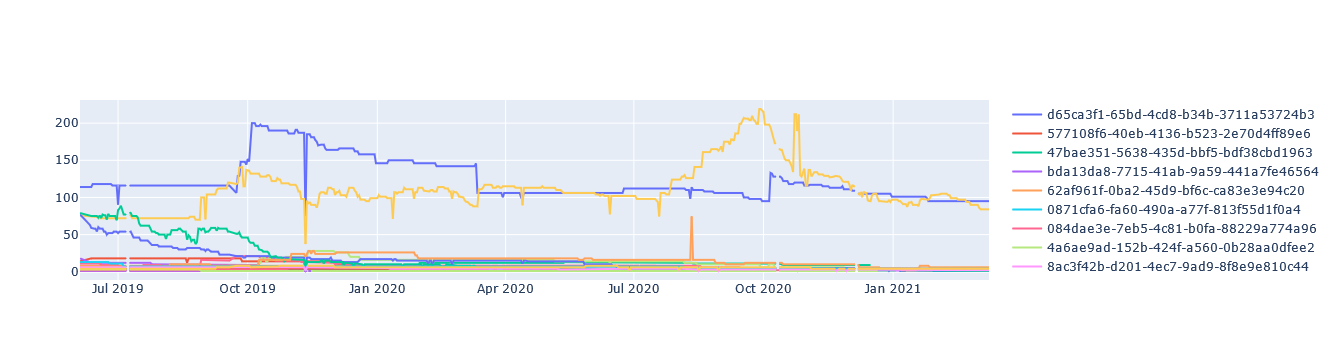

In [21]:
def plot_products_fluxes(stock_products):
    traces = []

    for col in stock_products.columns:
        traces.append(plotly.graph_objs.Scatter(
            x=stock_products.index.values,
            y=stock_products[col].values, 
            name=col))
    
    return plotly.offline.iplot(traces)

plot_products_fluxes(stock_products)

Ce graphique est très intéressant. On peut voir que le produit *48ae0499[...]* est sur-représenté comparé aux autres. Pour une prochaine analyse, il serait intéressant de ne se focaliser que sur les 20 produits les plus représentés.

Sur ce dernier produit, il est aussi intéressant de noter que l'on voit un début de cycle, avec une grosse augmentation du stock entre mi-juillet et début octobre, puis une chute jusqu'à janvier. On observe un plateau le reste du temps.

Pour le produit *756b[...]*, il est intéressant de voir une grosse chute de fin 2019 à début 2020, puis plus de sock: (courbe isolée en double cliquant sur son nom dans la légende, à droite)

![](https://puu.sh/HXr5f/03fe97b397.png)

Finalement, regardons les 18 autres produits brièvement. On voit qu'ils sont présent généralement en faible quantité et qu'il n'y a pas de réelles tendances intéressante.

![](https://puu.sh/HXr7S/b932ec99eb.png)

> Tout ceci nous amène à nous concentrer que sur quelques produits. Selectionnons le top 20 des produits et analysons les.

[Back to top](#top)

---
### 2.4. Analyse des 20 produits les plus échangés<a id="TestPsycle_2-4"></a>

In [22]:
# Init
stock_all_products = {}.fromkeys(unique_products, 0)


# Progress bar
f = IntProgress(min=0, max=len(pd.date_range(start='2019-06-04', end='2021-03-11')))
display(f) # display the bar

for date in pd.date_range(start='2019-06-04', end='2021-03-11'):
    f.value += 1 # signal to increment the progress bar
    # Set the path (with leading zeros if needed)
    file = str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

    # Verify if the file exists
    if not os.path.isfile(PATH + file + '.csv'):
        continue

    # Get the CSV
    df_temp = open_one_day_csv(file).groupby(['product_id']).sum()
    
    for product in unique_products:
        if product in df_temp.index.values:
            stock_all_products[product] += df_temp.at[product, 'quantity']
    
stock_all_products = pd.DataFrame({'product_id': stock_all_products.keys(), 'flux': stock_all_products.values()})
stock_all_products.head()

IntProgress(value=0, max=647)

product_id   flux
0  d65ca3f1-65bd-4cd8-b34b-3711a53724b3  77705
1  577108f6-40eb-4136-b523-2e70d4ff89e6   3636
2  47bae351-5638-435d-bbf5-bdf38cbd1963   4275
3  bda13da8-7715-41ab-9a59-441a7fe46564   2907
4  62af961f-0ba2-45d9-bf6c-ca83e3e94c20   4096

In [23]:
stock_all_products = stock_all_products.sort_values('flux')
stock_all_products

product_id     flux
6266  e6f5cf92-3cf2-48d3-83db-b29f321660ad        1
6369  e7fec234-2e25-4b27-b61d-22a0633fec49        1
7126  92e98dbc-5c3c-451e-b077-9c79b7eb5bad        1
7125  c0f0f288-fdb5-4939-b28f-a6ae396ed4e0        1
7123  bd6fc906-7df4-4e90-b108-813c955e6590        1
...                                    ...      ...
1611  b0df459a-a109-481e-a6fe-a2e755ef5468  2660078
1784  ad43d6ff-7b1f-43c8-a948-97529ccb5b81  3031515
1489  493791cc-8152-4a31-a0da-4a458a453efd  3043400
1985  950314ff-7136-471d-aaa5-0e3fa8fd6d64  3315525
3151  18da1bf1-f7c4-4da3-8aa3-b76f3f150f82  4000227

[7700 rows x 2 columns]

In [24]:
stock_all_products[-20:]

product_id     flux
2730  e73f0f57-b1e1-46b0-9b14-69c8b185771d  1173154
3821  12ae78e6-26c3-4bae-bdb7-fcedc0ac6a13  1181615
525   211c0145-0b7f-48c1-94ef-d431ad0f3c3b  1220897
1653  5760545b-76b6-4fb0-9f56-4fff9e794f58  1324165
2221  48ae0499-b0a0-4e6d-bb65-57e396974210  1487218
1752  0a17926e-03b4-49cb-b4a9-cae54b59deb5  1565913
2762  102f0895-e685-4efa-8852-460b62faaa3e  1598733
878   339e2f6c-55e6-4b51-ad78-04c8d1d93694  1711956
4711  43246578-7fb8-4e4d-b957-6bfb4401f666  1728205
3052  81a49a83-0c5d-4700-9a3a-cdd13a2a4637  1738391
3796  756e4029-2be1-4e34-93e6-becacabcb318  1801620
3446  14bf392e-2794-4529-aa91-eecf2299e269  1814679
1263  37de39c2-1321-4593-9137-d7802c816589  1982755
4732  5cacafe5-1d46-4150-ad29-010e38f5237c  2047267
4279  08d38586-f25c-49f8-a69b-0399b902c7d6  2355632
1611  b0df459a-a109-481e-a6fe-a2e755ef5468  2660078
1784  ad43d6ff-7b1f-43c8-a948-97529ccb5b81  3031515
1489  493791cc-8152-4a31-a0da-4a458a453efd  3043400
1985  950314ff-7136-471d-aaa5-0e3fa8fd6d64  3315525
3151  18da1bf1-f7c4-4da3-8aa3-b76f3f150f82  4000227

IntProgress(value=0, max=647)

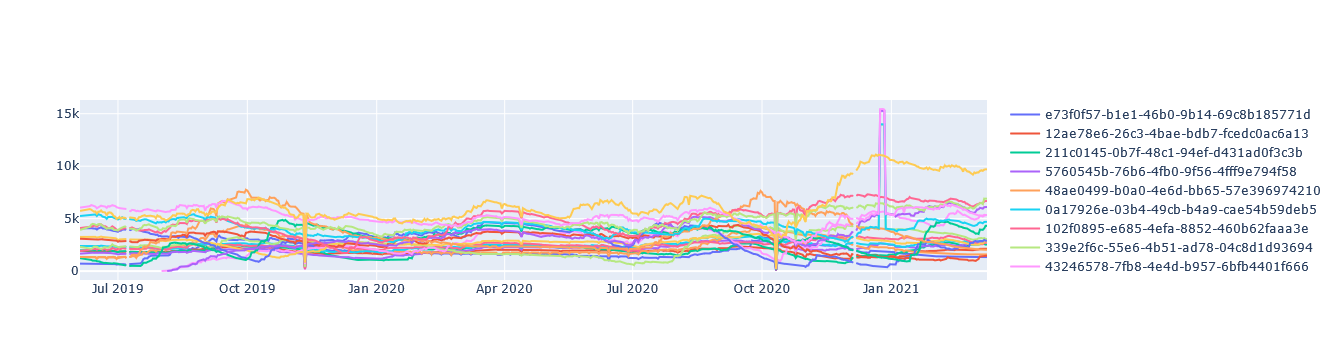

In [25]:
stock_products = get_products_fluxes(stock_all_products[-20:].product_id.values)
plot_products_fluxes(stock_products)

Ce graphique est très intéressant car on voit clairement que le pic de stock autour du 25 décembre 2020 ne concerne pas tous les produits, mais pas un seul non plus. On voit clairement cela en ne selectionnant que 5 produits, où l'on voit pour les produits *b0df[...]* et *5cacafe[...]* qu'il y a 10K d'augmentation : 
![](https://puu.sh/HXrrX/b56a1c471d.png)

Cela nous conduit une nouvelle fois à une possible erreur, ici un possible "1" qui "se serait inséré" par inadvertance.

Notons que cependant que sur ce graphique, 20 courbes c'est beaucoup. Découpons en 4 graphiques avec 5 courbes chacuns :stock_products

In [26]:
stock_all_products

product_id     flux
6266  e6f5cf92-3cf2-48d3-83db-b29f321660ad        1
6369  e7fec234-2e25-4b27-b61d-22a0633fec49        1
7126  92e98dbc-5c3c-451e-b077-9c79b7eb5bad        1
7125  c0f0f288-fdb5-4939-b28f-a6ae396ed4e0        1
7123  bd6fc906-7df4-4e90-b108-813c955e6590        1
...                                    ...      ...
1611  b0df459a-a109-481e-a6fe-a2e755ef5468  2660078
1784  ad43d6ff-7b1f-43c8-a948-97529ccb5b81  3031515
1489  493791cc-8152-4a31-a0da-4a458a453efd  3043400
1985  950314ff-7136-471d-aaa5-0e3fa8fd6d64  3315525
3151  18da1bf1-f7c4-4da3-8aa3-b76f3f150f82  4000227

[7700 rows x 2 columns]

IntProgress(value=0, max=647)

The 1 to 0 most represented products :


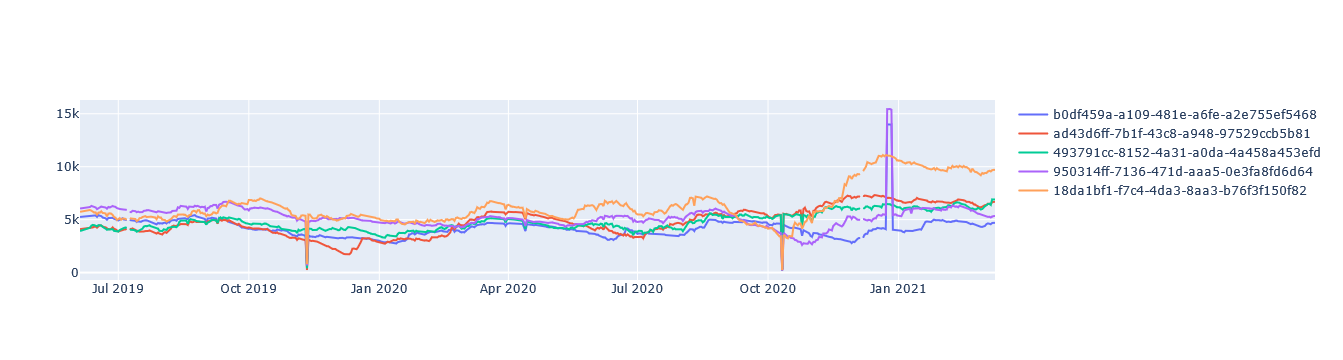

The 6 to 5 most represented products :


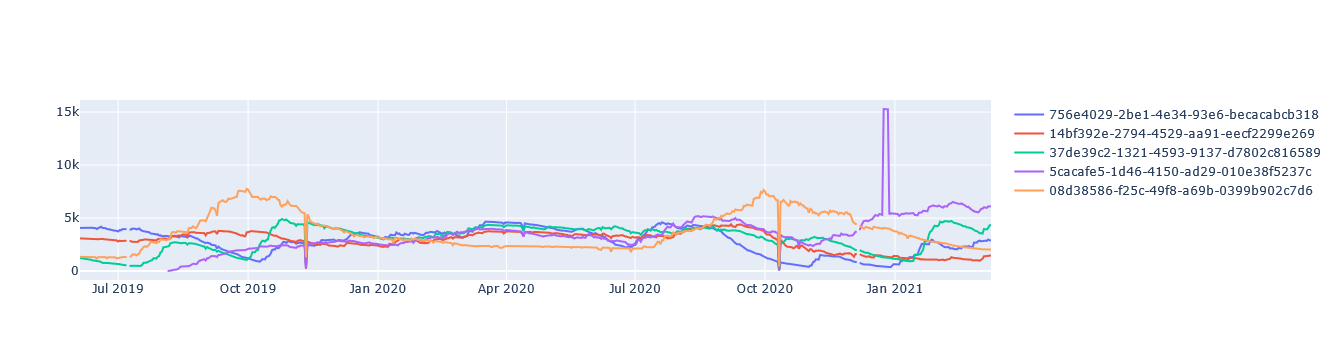

The 11 to 10 most represented products :


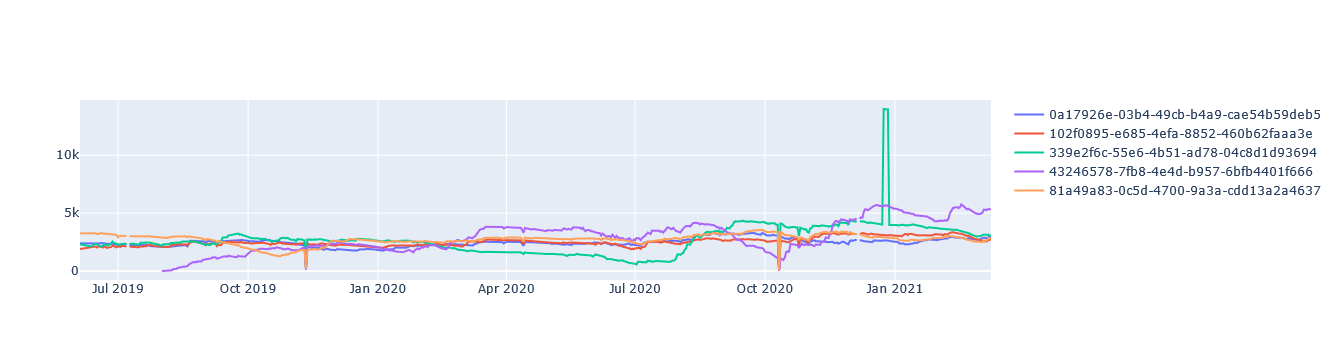

The 16 to 15 most represented products :


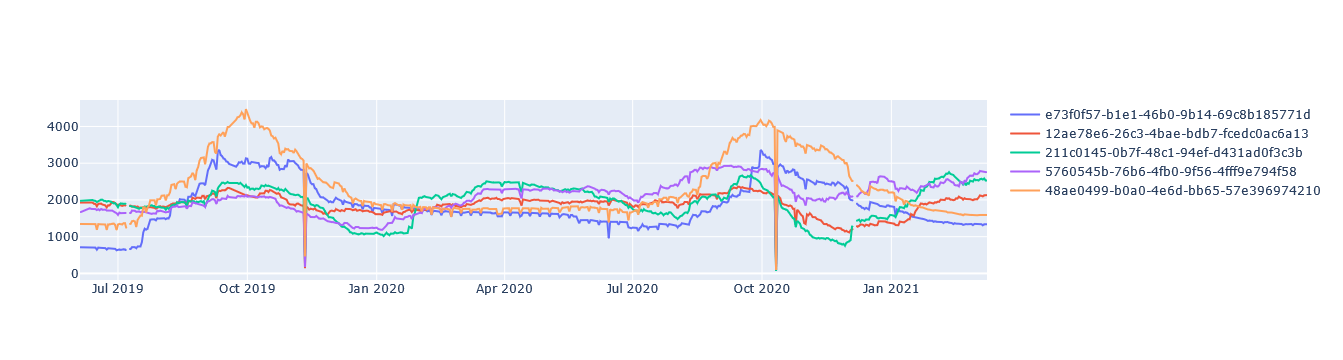

product_id     flux
2730  e73f0f57-b1e1-46b0-9b14-69c8b185771d  1173154
3821  12ae78e6-26c3-4bae-bdb7-fcedc0ac6a13  1181615
525   211c0145-0b7f-48c1-94ef-d431ad0f3c3b  1220897
1653  5760545b-76b6-4fb0-9f56-4fff9e794f58  1324165
2221  48ae0499-b0a0-4e6d-bb65-57e396974210  1487218
1752  0a17926e-03b4-49cb-b4a9-cae54b59deb5  1565913
2762  102f0895-e685-4efa-8852-460b62faaa3e  1598733
878   339e2f6c-55e6-4b51-ad78-04c8d1d93694  1711956
4711  43246578-7fb8-4e4d-b957-6bfb4401f666  1728205
3052  81a49a83-0c5d-4700-9a3a-cdd13a2a4637  1738391
3796  756e4029-2be1-4e34-93e6-becacabcb318  1801620
3446  14bf392e-2794-4529-aa91-eecf2299e269  1814679
1263  37de39c2-1321-4593-9137-d7802c816589  1982755
4732  5cacafe5-1d46-4150-ad29-010e38f5237c  2047267
4279  08d38586-f25c-49f8-a69b-0399b902c7d6  2355632
1611  b0df459a-a109-481e-a6fe-a2e755ef5468  2660078
1784  ad43d6ff-7b1f-43c8-a948-97529ccb5b81  3031515
1489  493791cc-8152-4a31-a0da-4a458a453efd  3043400
1985  950314ff-7136-471d-aaa5-0e3fa8fd6d64  3315525
3151  18da1bf1-f7c4-4da3-8aa3-b76f3f150f82  4000227

In [27]:
nb_trace = 5
nb_plot = 4

stock_products = get_products_fluxes(stock_all_products[-(nb_plot*(nb_trace+1)):].product_id.values)

for i in range(nb_plot):
    print(f'The {(1 + i*nb_trace)} to {i*nb_trace} most represented products :')

    if i == 0:
        plot_products_fluxes(stock_products.iloc[:,-nb_trace:])                     
    else:
        plot_products_fluxes(stock_products.iloc[:,-(i*nb_trace + nb_trace):-(i*nb_trace)])

stock_all_products[-(i*nb_trace + nb_trace):]

Petite note : le code n'est pas optimisé, il supporterait assez mal une grosse charge. Ici le but est principalement d'avoir un rapide apperçu des données.

On voit encore une fois que certaines courbe sont assez plates et peu intéressantes à étudier. Pour ces dernières, une recommandation pourrait être de réduire le stock sachant qu'il y a peu de variation de ce dernier.

Pour les courbes plus cycliques, il serait intéressant de faire du prédictif, comme ici:
- 08d38586-f25c-49f8-a69b-0399b902c7d6
- 48ae0499-b0a0-4e6d-bb65-57e396974210

Ou encore, dans une moindre mesure :
- 211c0145-0b7f-48c1-94ef-d431ad0f3c3b
- e73f0f57-b1e1-46b0-9b14-69c8b185771d

Avant d'analyser pour un client, regardons ce que peut nous donner un tableau de corrélation :

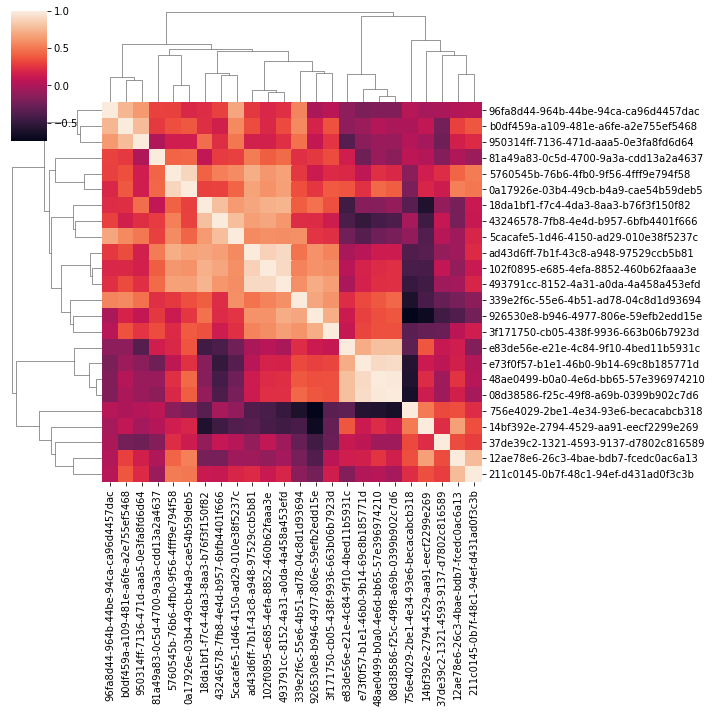

In [28]:
sns.clustermap(stock_products.corr())

Il est intéressant de voir quelques groupes de produits se former. Analysons sur plus de produits:

IntProgress(value=0, max=647)

D:\Anaconda3\lib\site-packages\seaborn\matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



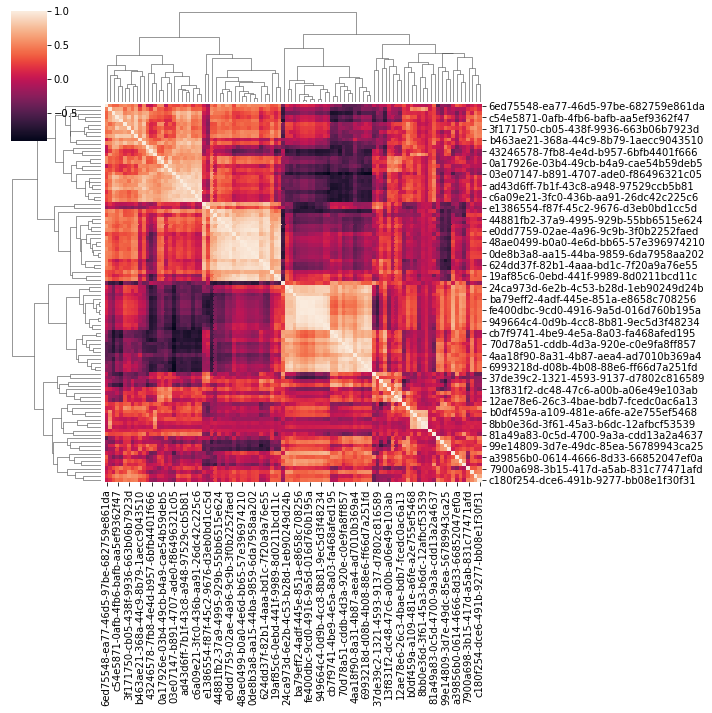

In [29]:
stock_products = get_products_fluxes(stock_all_products[-100:].product_id.values)
sns.clustermap(stock_products.corr())

C'est très jolie et nous voyons une nouvelle fois des tendances se dégager. On peut supposer qu'il s'agisse de différentes familles de céréales dont les phases de récoltes et d'utilisation sont très proches.

Juste pour le test, voyons avec 1000 features (je ne pousserais pas plus avec un code peu optimisé et un ordinateur (portable) assez agé)

IntProgress(value=0, max=647)

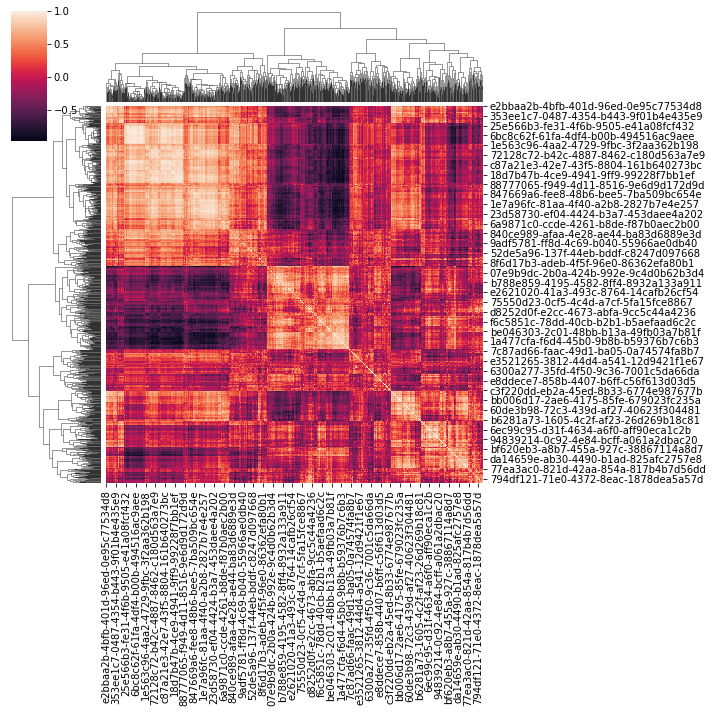

In [30]:
stock_products = get_products_fluxes(stock_all_products[-1000:].product_id.values)
sns.clustermap(stock_products.corr())

In [31]:
def get_products_fluxes_for_a_client(unique_selected_products, client_id, start='2019-06-04', end='2021-03-11'):
    # Init
    stock_products = {}.fromkeys(unique_selected_products, [])
    for key in stock_products.keys():
        stock_products[key] = []
    stock_products_date = []

    # Progress bar
    f = IntProgress(min=0, max=len(pd.date_range(start=start, end=end)))
    display(f) # display the bar

    for date in pd.date_range(start=start, end=end):
        f.value += 1 # signal to increment the progress bar
        # Set the path (with leading zeros if needed)
        file = str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

        # Verify if the file exists
        if not os.path.isfile(PATH + file + '.csv'):
            continue

        # Get the CSV
        df = open_one_day_csv(file)
        df = df.loc[df.client_id == client_id, ['product_id', 'quantity']].groupby('product_id').sum()

        # Save the data
        # stock_products.get('date').append(date)
        stock_products_date.append(date)

        for product in unique_selected_products:
            if product in df.index.values:
                stock_products.get(product).append(df.at[product, 'quantity'])
            else:
                stock_products.get(product).append(np.nan)

    return pd.DataFrame(stock_products, index=stock_products_date, columns=unique_selected_products)



selected_products = stock_all_products[-20:].product_id.values # ['08d38586-f25c-49f8-a69b-0399b902c7d6', '48ae0499-b0a0-4e6d-bb65-57e396974210']
selected_client = 'ba5701a0-7085-415f-96f4-2d922e812b7b'

stock_products = get_products_fluxes_for_a_client(selected_products, selected_client)

stock_products.head()

IntProgress(value=0, max=647)

e73f0f57-b1e1-46b0-9b14-69c8b185771d  \
2019-06-04                                   2.0   
2019-06-11                                   2.0   
2019-06-12                                   2.0   
2019-06-13                                   2.0   
2019-06-14                                   2.0   

            12ae78e6-26c3-4bae-bdb7-fcedc0ac6a13  \
2019-06-04                                  34.0   
2019-06-11                                  34.0   
2019-06-12                                  34.0   
2019-06-13                                  34.0   
2019-06-14                                  34.0   

            211c0145-0b7f-48c1-94ef-d431ad0f3c3b  \
2019-06-04                                  50.0   
2019-06-11                                  74.0   
2019-06-12                                  72.0   
2019-06-13                                  72.0   
2019-06-14                                  72.0   

            5760545b-76b6-4fb0-9f56-4fff9e794f58  \
2019-06-04                                  60.0   
2019-06-11                                  76.0   
2019-06-12                                  76.0   
2019-06-13                                  76.0   
2019-06-14                                  76.0   

            48ae0499-b0a0-4e6d-bb65-57e396974210  \
2019-06-04                                   4.0   
2019-06-11                                   4.0   
2019-06-12                                   4.0   
2019-06-13                                   4.0   
2019-06-14                                   4.0   

            0a17926e-03b4-49cb-b4a9-cae54b59deb5  \
2019-06-04                                  24.0   
2019-06-11                                  46.0   
2019-06-12                                  46.0   
2019-06-13                                  46.0   
2019-06-14                                  46.0   

            102f0895-e685-4efa-8852-460b62faaa3e  \
2019-06-04                                  56.0   
2019-06-11                                  32.0   
2019-06-12                                  32.0   
2019-06-13                                  30.0   
2019-06-14                                  28.0   

            339e2f6c-55e6-4b51-ad78-04c8d1d93694  \
2019-06-04                                  16.0   
2019-06-11                                  11.0   
2019-06-12                                   7.0   
2019-06-13                                   3.0   
2019-06-14                                   3.0   

            43246578-7fb8-4e4d-b957-6bfb4401f666  \
2019-06-04                                   NaN   
2019-06-11                                   NaN   
2019-06-12                                   NaN   
2019-06-13                                   NaN   
2019-06-14                                   NaN   

            81a49a83-0c5d-4700-9a3a-cdd13a2a4637  \
2019-06-04                                  92.0   
2019-06-11                                 124.0   
2019-06-12                                 124.0   
2019-06-13                                 120.0   
2019-06-14                                 120.0   

            756e4029-2be1-4e34-93e6-becacabcb318  \
2019-06-04                                  41.0   
2019-06-11                                  86.0   
2019-06-12                                  86.0   
2019-06-13                                  84.0   
2019-06-14                                  82.0   

            14bf392e-2794-4529-aa91-eecf2299e269  \
2019-06-04                                  93.0   
2019-06-11                                  91.0   
2019-06-12                                  91.0   
2019-06-13                                  91.0   
2019-06-14                                  91.0   

            37de39c2-1321-4593-9137-d7802c816589  \
2019-06-04                                   NaN   
2019-06-11                                   6.0   
2019-06-12                                   2.0   
2019-06-13                                   2.0

The 1 to 5 most represented products :


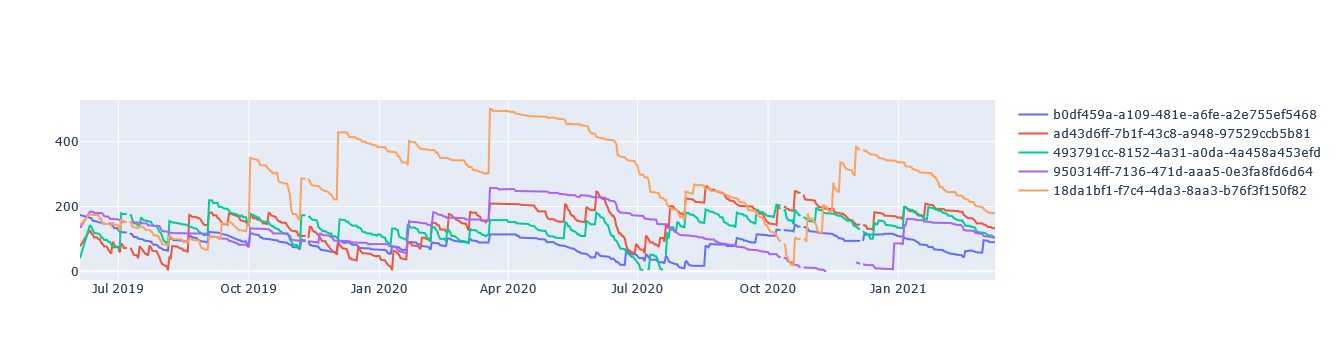

The 6 to 10 most represented products :


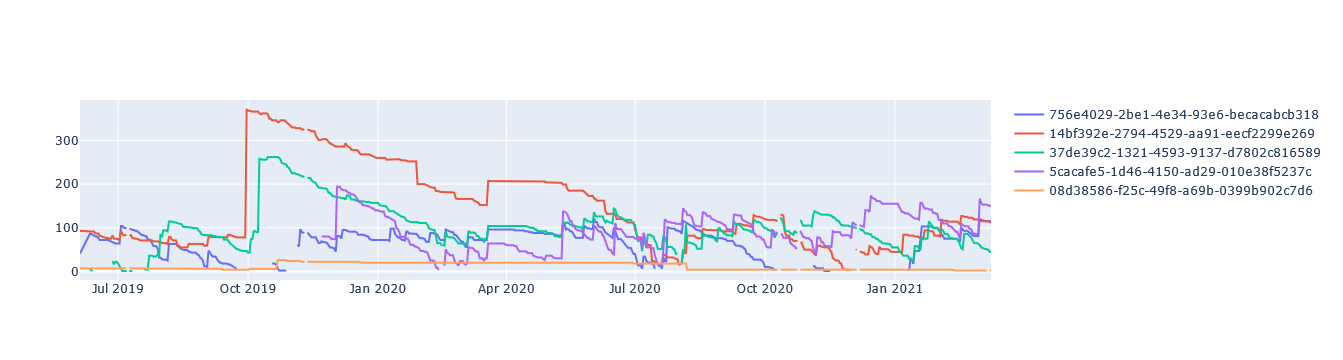

The 11 to 15 most represented products :


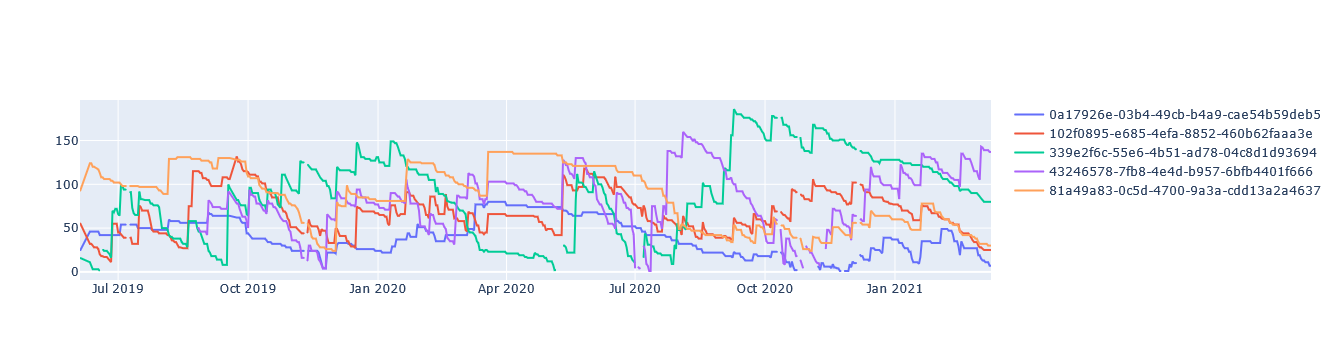

The 16 to 20 most represented products :


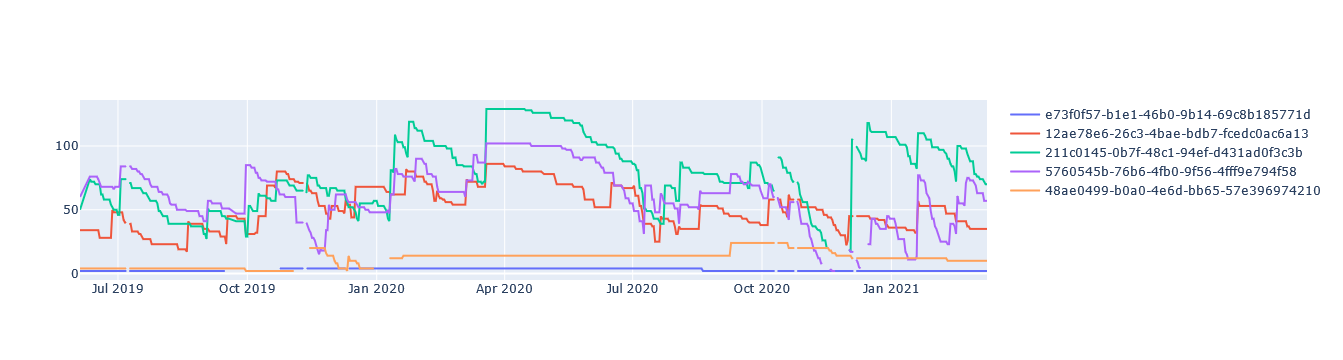

product_id     flux
2730  e73f0f57-b1e1-46b0-9b14-69c8b185771d  1173154
3821  12ae78e6-26c3-4bae-bdb7-fcedc0ac6a13  1181615
525   211c0145-0b7f-48c1-94ef-d431ad0f3c3b  1220897
1653  5760545b-76b6-4fb0-9f56-4fff9e794f58  1324165
2221  48ae0499-b0a0-4e6d-bb65-57e396974210  1487218
1752  0a17926e-03b4-49cb-b4a9-cae54b59deb5  1565913
2762  102f0895-e685-4efa-8852-460b62faaa3e  1598733
878   339e2f6c-55e6-4b51-ad78-04c8d1d93694  1711956
4711  43246578-7fb8-4e4d-b957-6bfb4401f666  1728205
3052  81a49a83-0c5d-4700-9a3a-cdd13a2a4637  1738391
3796  756e4029-2be1-4e34-93e6-becacabcb318  1801620
3446  14bf392e-2794-4529-aa91-eecf2299e269  1814679
1263  37de39c2-1321-4593-9137-d7802c816589  1982755
4732  5cacafe5-1d46-4150-ad29-010e38f5237c  2047267
4279  08d38586-f25c-49f8-a69b-0399b902c7d6  2355632
1611  b0df459a-a109-481e-a6fe-a2e755ef5468  2660078
1784  ad43d6ff-7b1f-43c8-a948-97529ccb5b81  3031515
1489  493791cc-8152-4a31-a0da-4a458a453efd  3043400
1985  950314ff-7136-471d-aaa5-0e3fa8fd6d64  3315525
3151  18da1bf1-f7c4-4da3-8aa3-b76f3f150f82  4000227

In [32]:
for i in range(nb_plot):
    print(f'The {(1 + i*nb_trace)} to {nb_trace + i*nb_trace} most represented products :')

    if i == 0:
        plot_products_fluxes(stock_products.iloc[:,-nb_trace:])                     
    else:
        plot_products_fluxes(stock_products.iloc[:,-(i*nb_trace + nb_trace):-(i*nb_trace)])

stock_all_products[-(i*nb_trace + nb_trace):]

[Back to top](#top)

---
## 3. Pre traitement des données<a id="TestPsycle_3"></a>

Ici, nous allons étudier des timeseries: pour un client et un produit, l'évolution du stock par jour.

**Train set / Test set**  
Ici, je pense que l'on manque de données pour avoir un train et test sets sur un même produit. Il aurait été intéressant d'avoir au moins 4 cycles, pour avoir 3 cycles de train set et un cycle de test.

Une solution pourrait être de prendre un autre produit pour faire le test.

**Nettoyage des données**  
- Élimination des NaN / valeurs abberantes (notamment pour le modèle final) si possible
- Encodage pour faciliter l'apprentissage machine + Feature Scaling

**Feature Selection**
Nous ne resterons que sur quelques produits où nous voyons un cycle se dessiner.

**Feature Engineering**
On peut analyser les stock dans leur globalité.


Commençont par faire un dataset propre :


---
## 4. Modelling<a id="TestPsycle_4"></a>

TODO
- Définir une fonction d'évaluation
- Entrainement de différents modèles
- Optimisation avec GridSearchCV
- Analyse des erreurs et retour au preprocessing / EDA si nécessaire
- Learning curve
- Tester ARIMA

In [33]:
product = '48ae0499-b0a0-4e6d-bb65-57e396974210'
df_modelling = get_products_fluxes([product])

IntProgress(value=0, max=647)

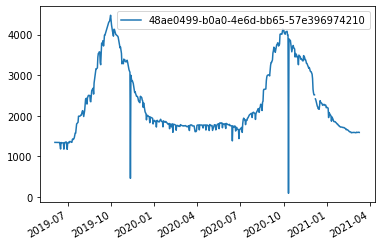

In [34]:
df_analyze = df_modelling.copy()
train_set, test_set = train_test_split(df_analyze, test_size=.2)
train_set.plot();

En fait ça n'ira pas, on ne veut pas prédire des valeurs manquante mais le futur, donc on ne va "supprimer" que la fin qui servira de test set

In [35]:
def feature_engineering(df):
    df.resample('D')
    return df.asfreq('D')

In [36]:
def imputation(df, product):
    # Suppress strange values
    df.loc[df[product] < 1000] = np.nan
    # Replace it by the mean of prev/next values
    df[product] = df[product].interpolate()
    return df

In [37]:
# Data scaling
def feature_scaling(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data)
    return data

<AxesSubplot:>

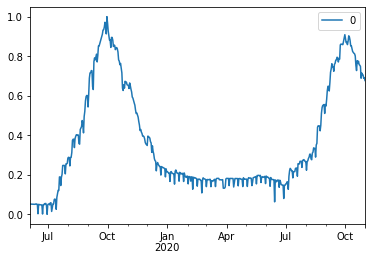

In [38]:
def preprocessing(df, product, train_set_size=.8):
    df = feature_engineering(df)
    df = imputation(df, product)
    
    X_train = df[:int(len(df) * train_set_size)].index
    X_test = df[int(len(df) * train_set_size):].index
    
    df = feature_scaling(df)
    
    y_train = df[:int(len(df) * train_set_size)]
    y_test = df[int(len(df) * train_set_size):]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocessing(df_analyze, product, train_set_size=.8)

pd.DataFrame(y_train, index=X_train).plot()

Je pense que pour notre model, il est possible de ne pas créer de test set. En effet, on connait approximativement la forme de la courbe, on pourra vite savoir si l'apprentissage est intéressant ou non.

In [39]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

In [40]:
from sklearn.neural_network import MLPRegressor

X = np.array(X_train.map(dt.datetime.toordinal)).reshape(len(y_train), 1)
y = np.array(y_train).ravel()

model = MLPRegressor(hidden_layer_sizes=(20, 20, 15, 10), max_iter=100000)
model.fit(X, y)
model.score(X, y)

-28852.585512401383

In [41]:
np.arange(X[-1], X[-1]+100)

array([737729, 737730, 737731, 737732, 737733, 737734, 737735, 737736,
       737737, 737738, 737739, 737740, 737741, 737742, 737743, 737744,
       737745, 737746, 737747, 737748, 737749, 737750, 737751, 737752,
       737753, 737754, 737755, 737756, 737757, 737758, 737759, 737760,
       737761, 737762, 737763, 737764, 737765, 737766, 737767, 737768,
       737769, 737770, 737771, 737772, 737773, 737774, 737775, 737776,
       737777, 737778, 737779, 737780, 737781, 737782, 737783, 737784,
       737785, 737786, 737787, 737788, 737789, 737790, 737791, 737792,
       737793, 737794, 737795, 737796, 737797, 737798, 737799, 737800,
       737801, 737802, 737803, 737804, 737805, 737806, 737807, 737808,
       737809, 737810, 737811, 737812, 737813, 737814, 737815, 737816,
       737817, 737818, 737819, 737820, 737821, 737822, 737823, 737824,
       737825, 737826, 737827, 737828], dtype=int64)

0.9472939561580298


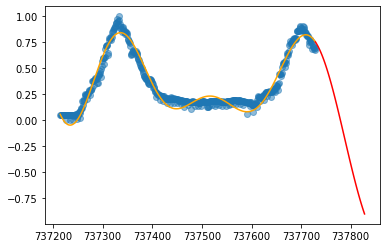

In [42]:
from sklearn.svm import SVR

model = SVR(degree=5, C=100)
model.fit(X, y) 
print(model.score(X, y)) 

X_pred = np.arange(X[-1], X[-1]+100).reshape(-1, 1)
y_pred = model.predict(X_pred)

plt.scatter(X, y, alpha=.5)
plt.plot(X, model.predict(X), c='orange')
plt.plot(X_pred, y_pred, c='r')

ce n'est clairement pas bon 

<AxesSubplot:>

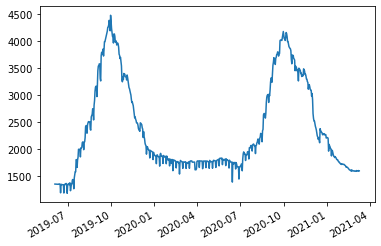

In [43]:
df_analyze = df_modelling.copy()

# Suppress strange values
df_analyze.loc[df_analyze[product] < 1000] = np.nan
# Replace it by the mean of prev/next values
df_analyze = df_analyze[product].interpolate()
df_analyze.plot()

<AxesSubplot:>

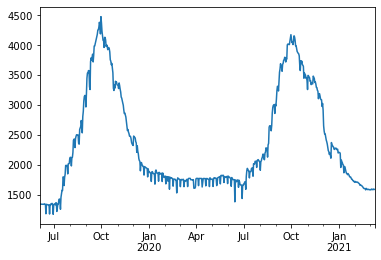

In [44]:
df_analyze.resample('D')
df_analyze = df_analyze.asfreq('D')
df_analyze = df_analyze.interpolate()

df_analyze.plot()

In [45]:
rolling_mean = df_analyze.rolling(window=12).mean()
rolling_std = df_analyze.rolling(window=12).std()

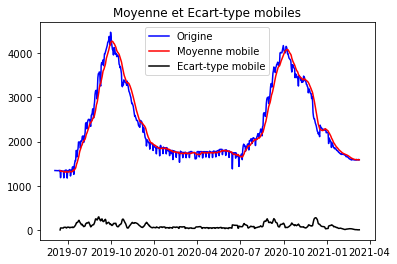

In [46]:
plt.plot(df_analyze, color = 'blue', label = 'Origine')
plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
plt.legend(loc = 'best')
plt.title('Moyenne et Ecart-type mobiles')
plt.show()

D:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


D:\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note

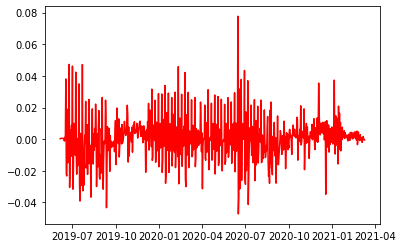

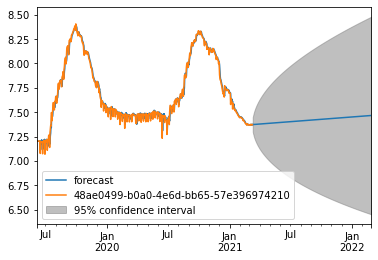

In [47]:
df_analyze_log = np.log(df_analyze)
decomposition = seasonal_decompose(df_analyze_log) 

model = ARIMA(df_analyze_log, order=(2,1,2))
results = model.fit(disp=-1)

plt.plot(results.fittedvalues, color='red')
fig = results.plot_predict(1,1000)

Ce n'est absolument pas convaincant. C'est possiblement un manque de data, on peut voir un début de cycle sur une année, mais nous n'avons des données que sur 1.5 ans.

[Back to top](#top)

---
## 5. Résultats & conclusion<a id="TestPsycle_5"></a>


### Analyse des données

L'analyse de forme m'a permit de clairement identifier une table de fait d'un modèle en étoile. Nous avons 3 colonnes:

- client_id et product_id qui sont qualitative

- quantity qui est quantitative


Le dataset comprend un total de 26 955 284 lignes, dont :

- 333 clients uniques

- 7700 produits uniques


Chaque fichier correspond à une journée. Il est intéressant de noter que :

- il manque 10 journées / fichiers

- il y a 4 fichiers / journées avec des valeurs surprenamment basses ou nulles.

1. 2019-07-08 0.0

2. 2019-11-11 56892.0

3. 2020-10-11 13629.0

4. 2020-12-06 0.0

> J'ai supposé qu'il s'agissait de 4 journées avec des problèmes dans les données

- Il y a 4 journées de suite avec des valeurs surprenamment hautes, du 24 décembre au 27 décembre 2020

> Par la suite j'ai pu constater que pendant ces 4 jours, certains produits avaient +10 000 de stock. J'ai supposé qu'il s'agissait d'une erreur de saisie où un "1" s'est glissé par inadvertance.


Ces deux hypothèses seraient à confirmer avec le client si cela est possible. Pour le modèle, j'ai supposé qu'il s'agissait réellement d'erreurs afin de "supprimer" ces aberrations risquant de compromettre l'apprentissage. Plus exactement, j'ai remplacé les valeurs manquantes par la moyenne entre les valeurs précédente et suivante. En effet, il est assez peu probable d'avoir une très grosse variation de stock en seulement 2 jours.


Une analyse générale de tout produit confondus à travers le temps m'a permis de repérer un début de cycle avec une hausse courant septembre. Cela coïncide avec une période de récolte. Une autre hausse est observable en avril, cependant par manque de données il est compliqué de déterminer s'il s'agit d'un cycle ou non.


En effet, sachant que l'agriculture est cyclique sur une année, il aurait été intéressant de posséder plus de données, sur au moins 3 ans, afin de réellement observer des cycles se former.


Une analyse détaillée de quelques produits a permis de faire ressortir différentes catégories de produits:

- Certains augmentent en quantité courant les mois de septembre

- Certains sont assez constants dans le temps

- Certains ne sont présents qu'en une très faible quantité

- Certains n'ont pas de cycles qui semblent ressortir de l'analyse

Ceci a été notamment confirmé grâce à une matrice de corrélation sur les 100 produits les plus présents, ayant clairement fait ressortir des groupes de produits très corrélés.




### Modélisation

Afin de réaliser un premier test assez simple, j'ai sélectionné le produit *'48ae0499-b0a0-4e6d-bb65-57e396974210'* qui semble suivre un cycle d'un an, avec un stock qui se remplie de mi-juillet à début octobre, puis qui baisse jusqu'en début d'année.


Après avoir normalisé les données, j'ai cherché à :

- Faire une régression avec scikit sans réussir à trouver un résultat convainquant.

- Faire une prédiction avec le modèle ARIMA sans réussir à trouver un résultat convainquant.


Il aurait été intéressant de tenter une analyse avec du deep learning en ANN ou même en RNN, sachant que l'on a des cycles, et que la valeur n+1 dépend de la valeur n.


Je n'ai malheureusement pas réussi à trouver comment réaliser le modèle avec les timeseries. Mes tests ne sont absolument pas convaincants. Je pense que d'un côté, je m'y suis mal pris et je manque d'expérience, de l'autre côté, plus de données afin d'avoir une vision sur plusieurs cycles aurait possiblement été un plus.




### Conclusion

À ce niveau d'analyse, il est intéressant de noter que certains produits sont assez 'résiduels'. Se demander si les garder à un sens pourrait déjà aider à optimiser le stock. En effet, on observe un très grand nombre de produits, mais dont la grande majorité n'est presque pas présente :

![](https://puu.sh/HXxzZ/b6cd2ae312.png)

Analyse sur 1 an et demi


Un autre point qui pourrait être intéressant, serait d'étudier s'il est possible de réduire la marge de certains produits très présents sachant que l'on peut remarquer une variation assez cyclique.

[Back to top](#top)

---
## 6. Question bonus<a id="TestPsycle_6"></a>

En réalité les données de stocks sont issues de AWS S3. Des données supplémentaires sur les clients sont disponibles dans l'ERP de la coopérative. Ces données sont les suivantes :

Table `clients` :
- id => UUID4
- name
- group_id => appartenance à un groupe industriel
- address
- zip_code
- city

Table `clients_groups` :
- id => UUID4
- name
- address
- zip_code
- city

Table `products` :
- id => UUID4
- type
- name
- origin_id => origine du produit, de quel agriculteur il provient

Table `origins` :
- id => UUID4
- name
- address
- zip_code
- city

La coopérative souhaite un système pouvant répondre aux questions suivantes :
- Quel type de céréale est le plus vendu ?
- Quelles zones géographiques recoivent la plus grande quantité de céréales ?
- De quelles zones géographiques proviennent les 10 meilleurs produits vendus ?

**Sur la base de ces informations, présentez une architecture de stockage de données qui permettrait de répondre à ces questions.**

Je réaliserai un modèle en étoile assez simple avec 2 dimensions :
- Client contenant les infos clients + groupe auquel il appartient
- Product, contenant les infos produit dont son origine

![](./test-analytics-data-engineer/model.png)
![](https://puu.sh/HXygE/b3e2c7bc4c.png)

De cette manière, on pourrait aisément faire :
```SQL
/* La céréale la plus vendu */
SELECT DIM_PRODUCT.product_type
    FROM FACT_SALES
    INNER JOIN DIM_PRODUCT
        ON FACT_SALES.id_product=DIM_PRODUCT.id_product
    ORDER BY FACT_SALES.quantity DESC
    LIMIT 1
    
    
/* Zone géographique avec le plus de céréales */    
SELECT DIM_CLIENT.client_city,  DIM_CLIENT.client_ZIP
    FROM FACT_SALES
    INNER JOIN DIM_CLIENT
        ON FACT_SALES.id_client=DIM_CLIENT.id_client
    ORDER BY FACT_SALES.quantity DESC
    LIMIT 1
    
/* Origine des top 10 céréales */    
SELECT DISTINCT DIM_PRODUCT.origin_name
    FROM FACT_SALES
    INNER JOIN DIM_PRODUCT
        ON FACT_SALES.id_product=DIM_PRODUCT.id_product
    ORDER BY FACT_SALES.quantity DESC
    LIMIT 10
```


Ici, j'ai supposé que *Quantity* contenant la quantité totale pour un client et un produit. On pourrait garder la division par jour et ainsi rajouter une dimension date, et une foreign key id_date dans *FACT_SALES*.

[Back to top](#top)

---

Thibault **Santonja**

2021